In [29]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.inelastic.core_loss import SubshellTransitions
from ase import units
from ase.io import read

# Core-loss

This tutorial demonstrates how to calculate an "energy-filtered" STEM image using abTEM. We show how to calculate projected overlap integrals following to C. Dwyer (see [https://doi.org/10.1016/j.ultramic.2005.03.005](https://doi.org/10.1016/j.ultramic.2005.03.005) and use them in a dynamical scattering simulation. We use the Density Functional Theory code [GPAW](https://wiki.fysik.dtu.dk/gpaw/index.html) for calculating the wave functions for the overlap integrals. Please see our citation guide if you use this code in a publication.

https://doi.org/10.1016/B978-0-12-407670-9.00003-2

We will first roughly reproduce the results of C. Dwyer, which the implementation is largely based on. In the second half of the tutorial, we present a the typical core-loss energy filtered simulation using abTEM.

## Core-loss transitions

The first step is to select the transitions. Here we target the *K*-edge of Silicon i.e. the 1*s* subshell; quantum numbers $(n, \ell) = (1, 0)$. In a hypothetical experiment, this would be roughly equivalent to only collecting electrons with an energy loss of $10 \ \mathrm{eV}$ above the ionization threshold of $1840 \ \mathrm{eV}$.

In [30]:
Z = 14  # atomic number
n = 1  # principal quantum number
l = 0  # azimuthal quantum number
xc = "PBE"  # exchange-correlation functional

Si_transitions = SubshellTransitions(Z=Z, n=n, l=l, xc="PBE", order=2, epsilon=10)

print("bound electron configuration:", Si_transitions.bound_configuration)
print("ionic electron configuration:", Si_transitions.excited_configuration)

bound electron configuration: 1s2 2s2 2p6 3s2 3p2
ionic electron configuration: 1s1 2s2 2p6 3s2 3p2


There is an infinite number of possible transitions from the bound state to the continuum, however, only transitions with small changes in orbital angular momentum quantum number, $\Delta \ell$, will to contribute meaningfully. Choosing a maximum transition order, $\Delta \ell_{max}$, we include only transitions with continuum orbital angular momentum quantum number:
$$
\ell' = \ell, \ell \pm 1, \ell \pm 2, \ldots , \ell \pm \Delta \ell_{max} \quad  \ell' \geq 0
$$
This is controlled by setting i.e. `order = 0` gives just the monopole term, `order = 1` gives also includes all dipole terms and `order = 2` includes up to all quadropole terms etc.

Given an orbital angular momentum quantum number $\ell$ (or $\ell'$) the possible magnetic quantum numbers are:

$$
m_{\ell} = -\ell, \ell + 1, \ldots, \ell \quad .
$$

Below we print the quantum numbers for the bound and continuum states up quadropole transitions:

In [31]:
for bound_state, continuum_state in Si_transitions.get_transition_quantum_numbers():
    print(f"(n, l, ml) → (l', ml') = {bound_state} → {continuum_state[1:]}")

(n, l, ml) → (l', ml') = (1, 0, 0) → (0, 0)
(n, l, ml) → (l', ml') = (1, 0, 0) → (1, -1)
(n, l, ml) → (l', ml') = (1, 0, 0) → (1, 0)
(n, l, ml) → (l', ml') = (1, 0, 0) → (1, 1)
(n, l, ml) → (l', ml') = (1, 0, 0) → (2, -2)
(n, l, ml) → (l', ml') = (1, 0, 0) → (2, -1)
(n, l, ml) → (l', ml') = (1, 0, 0) → (2, 0)
(n, l, ml) → (l', ml') = (1, 0, 0) → (2, 1)
(n, l, ml) → (l', ml') = (1, 0, 0) → (2, 2)


The wave functions for the bound and continuum states, the atomic wave functions can be written as products of radial and angular parts, i.e
$$
\phi_{nm\ell} = \frac{P_{n\ell}(r)}{r} Y_{\ell}^{m}(\hat{\bm{r}}) \quad \mathrm{and} \quad \phi_{nm\ell} = \frac{P_{\epsilon_f\ell'}(r)}{r} Y_{\ell'}^{m'}(\hat{\bm{r}}) \quad ,
$$

where $Y_{\ell}^{m}$ represent spherical harmonics. In *ab*TEM the radial wave functions, $P_{n\ell}$ and $P_{\epsilon_f\ell}$, are calculated using a all-electron DFT  with using the scalar-relatistically corrected Schrödinger equation. We can get the bound radial wave function, $P_{10}$, using `get_bound_wave_function` and the continuum wave function, $P_{\epsilon_f 0}$, $P_{\epsilon_f 1}$ and $P_{\epsilon_f 2}$, using `get_excited_wave_functions`.

In [32]:
bound_state = Si_transitions.get_bound_wave_function()
excited_states = Si_transitions.get_excited_wave_functions()

bound_state, excited_states

(<abtem.inelastic.core_loss.RadialWavefunction at 0x7facf8b46890>,
  <abtem.inelastic.core_loss.RadialWavefunction at 0x7fabd4c06fd0>])

Below we plot the the bound and radial wave functions, this is a reproduction of Fig. 1 in Dwyers paper. Note, that there are minor differences, as Dwyer uses a Herman–Skillman wave functions instead of DFT.

The left and right y-axes correspond to $P_{10}$ and $P_{\epsilon_f \ell '}$. The unit of length in the figure is the Bohr radius $a_0 = 0.529 \ \mathrm{\AA}$ and the unit of energy is the Rydberg energy $\mathrm{Ry} = 13.6 \ \mathrm{eV}$.

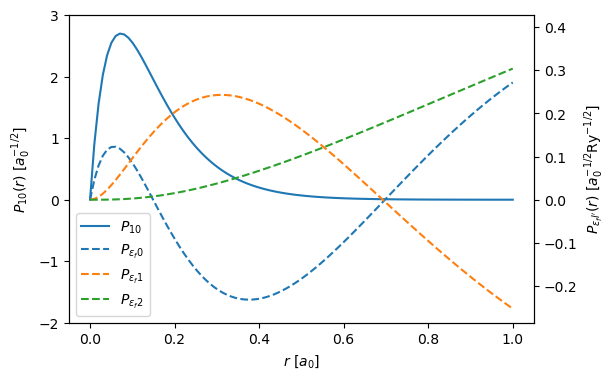

In [33]:
r = np.linspace(0, 1, 100)

fig, ax1 = plt.subplots(figsize=(6, 4))

lines = ax1.plot(r, bound_state(r), label="$P_{10}$")
ax1.set_ylim([-2, 3])

ax2 = ax1.twinx()

for excited_state in excited_states:
    lines += ax2.plot(
        r, excited_state(r), "--", label=f"$P_{{\epsilon_f {excited_state.l}}}$"
    )

ax2.set_ylim([-2 / 7, 3 / 7])

labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc=3)

ax1.set_ylabel("$P_{10}(r) \ [a_0^{-1/2}]$")
ax2.set_ylabel("$P_{{\epsilon_fl'}}(r) \ [a_0^{-1/2} \mathrm{Ry}^{-1/2}]$")
ax1.set_xlabel("$r \ [a_0]$");

## Transition potentials

We want to calculate the lateral part of the wave function of the inelastically scattered electrons, $\psi_{f}(\mathbf{r}_{\perp}, z)$, just after undergoing scattering at a depth $z$. We first calculate the elastic wave function $\psi_{i}(\mathbf{r}_{\perp}, z)$ at by propagating the wave function using multislice, then the inelastically scattered wave function may be given as a product with a projected transition potential
$$
    \psi_{f}(\mathbf{r}_{\perp}, z) = V_{fi}(\mathbf{r}_{\perp}) \psi_{i}(\mathbf{r}_{\perp}, z) \quad .
$$

The inelastic transition potential is given by
$$
V_{fi}(\mathbf{r}_{\perp}) = \int_{-\Delta z / 2}^{\Delta z / 2} \langle \phi_f | V_e | \phi_i \rangle e^{2 \pi i (k_i − k_f) z} \mathrm{d}z
$$
with
$$
\langle \phi_f | V_e | \phi_i \rangle = \int \phi^*_f(\mathbf{r}) \frac{e^2}{4\pi\epsilon_0 |\mathbf{r} - \mathbf{r}'|} \phi_i(\mathbf{r}') \mathrm{d}\mathbf{r}' \quad ,
$$
where the operator, $V_e$, is the Coulomb potential mediating the interaction, $\phi_i$ is the bound state of the transition and $\phi_f$ is one of the included continuum states.

We will from now on only include 1st order transitions, hence, we again create the `SubshellTransitions` for the Silicon *K*-edge setting `order=1`.

In [34]:
Si_transitions = SubshellTransitions(Z=Z, n=n, l=l, xc="PBE", order=1, epsilon=10)

for bound_state, continuum_state in Si_transitions.get_transition_quantum_numbers():
    print(f"(n, l, ml) -> (l', ml') = {bound_state} -> {continuum_state[1:]}")

(n, l, ml) -> (l', ml') = (1, 0, 0) -> (0, 0)
(n, l, ml) -> (l', ml') = (1, 0, 0) -> (1, -1)
(n, l, ml) -> (l', ml') = (1, 0, 0) -> (1, 0)
(n, l, ml) -> (l', ml') = (1, 0, 0) -> (1, 1)


We create the transition potentials for an incoming wave function with an energy of $100 \ \mathrm{keV}$, defined on a grid with $200 \times 200$ grid points and an extent of $2 \ \mathrm{Å}$.

In [35]:
transition_potential = Si_transitions.get_transition_potentials(
    gpts=200, extent=2, energy=100e3
)

We can show the complex transition potentials using domain coloring. This figure is equivalent in content to Fig. 2 in the Dwyer paper.

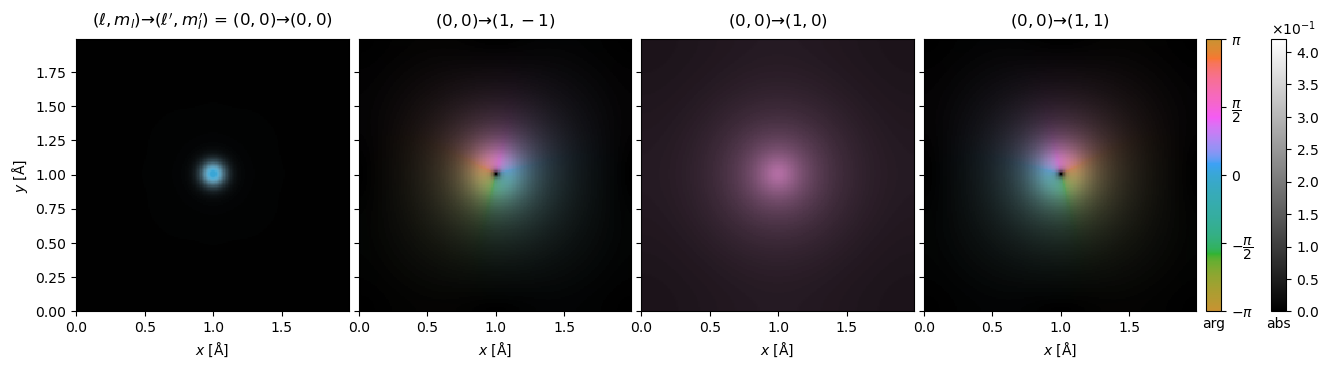

In [36]:
visualization = transition_potential.show(
    explode=True,
    figsize=(14, 4),
    cbar=True,
    common_color_scale=True,
    vmax=0.42,
)

## Energy differential cross-sections

```{note}
The following is not equivalent to a typical *ab*TEM simulation using a transition potential, see next section.
```

Next, we shall calculate the probabilty per unit energy (or energy differential cross-section) for core-loss scattering at a depth $z$ from a specific atom up to a given scattering angle $k_{cut}$

$$
\frac{\mathrm{d}\sigma}{\mathrm{d}E}\left(z\right) = \sigma^2  \int_{0}^{k_{cut}} A(k) \sum_{f} |\psi_f(\mathbf{k}_{\perp}, z)|^2 \ \mathrm{d}\mathbf{k} \quad ,
$$

where the rhs $\sigma$ is the interaction constant, $V_{fi}$ is the transition potential for a specified transiton of an atom in a specified position, $\psi(\mathbf{k}, z)$ is the reciprocal space wave function at a depth $z$ and $A(k)$ is the aperture function describing the maximum collection angle of the energy filter

$$
    A(k) = \begin{cases} 1 & \text{if } k \leq k_{cut} \\ 0 & \text{if } k > k_{cut} \end{cases} .
$$

This equation neglects all elastic scattering after the inelastic scattering event, sometimes called single-channeling. We describe the more accurate double-channeling, in the next section. 

The above equation is essentially equivalent Eq. 16 in the Dwyer paper, the main difference being that we integrate in reciprocal space. We shall roughly reproduce the bold full line shown in Fig. 4 of that paper, this is the result obtained by placing the beam on an atomic column and calculating the equation above for inealstic scattering from only atoms in that column. 

We create an atomic structure of silicon in the $\left<100\right>$ zone axis with a thickness $500 \ \mathrm{Å}$ and a converged lateral extent. Then we create a potential with exit planes every ten slices.

In [38]:
atoms = ase.build.bulk("Si", cubic=True) * (3, 3, 92)
atoms.center(axis=2)

potential = abtem.Potential(atoms, gpts=256, exit_planes=1, slice_thickness=5.43)

```{note}
In order to keep the calculation time lower 
```

We create the initial probe placed on the atomic column at $(0,0)$ with the same parameters as Dwyer and calculate the exit_waves for different thicknesses (i.e. $\psi_i(\mathbf{r}_{\perp}, z)$).

In [39]:
probe = abtem.Probe(
    semiangle_cutoff=30, energy=100e3, Cs=-0.053e-3 * 1e10, defocus=-90, C5=50e-3 * 1e10
)

wave = probe.multislice(potential, scan=(0, 0))

exit_waves = wave.compute()

tasks:   0%|          | 0/4 [00:00<?, ?it/s]

We can use the transition potentials to calculate the scattered waves, $\psi_f(\mathbf{k}_{\perp}, z)$, for scattering from an atoms placed at $(0,0)$ by setting `sites=(0,0)`.

In [40]:
transition_potentials = Si_transitions.get_transition_potentials()

scattered = transition_potentials.scatter(exit_waves, sites=(0, 0))

The scattered wave functions are returned as a 4D array, where the first axis represents the transitions, the second axis represents the exit planes and the last two dimensions represents the $xy$-plane.

In [41]:
scattered.shape

(4, 93, 256, 256)

Next, we calculate the incoherent sum over the transitions in reciprocal space, $\sum_{f} |\psi_f(\mathbf{k}_{\perp}, z)|^2$, by first getting the diffraction_patterns and then summing the first axis.

In [42]:
diffraction_patterns = scattered.diffraction_patterns().sum(0)

We show every twentieth "diffraction pattern" below.

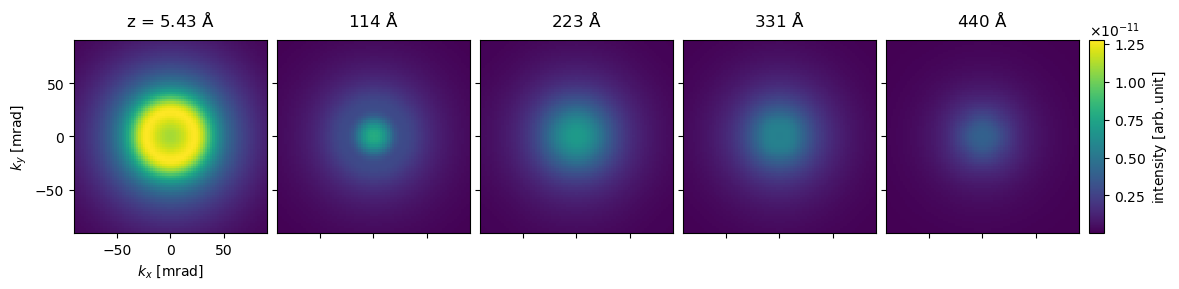

In [45]:
visualization = (
    diffraction_patterns[1::20]
    .crop(90)
    .show(
        explode=True, units="mrad", common_color_scale=True, cbar=True, figsize=(12, 5)
    )
)
visualization.axis("lower left", ticks=True)

To reproduce Fig. 4, we perform integrals with three different integration ranges from $0$ to $5$, $20$ and $50 \ \mathrm{mrad}$. The minor visible differences between Dwyers results and ours could be due to the slightly different atomic wave functions or because we neglected phonons to keep the demonstration simple.

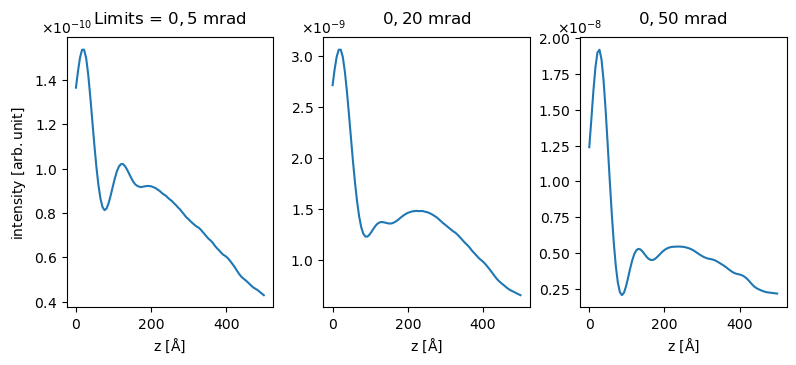

In [48]:
outer = (5, 20, 50)
measurements = diffraction_patterns.integrate_radial(inner=0, outer=outer)

measurements.show(explode=True, figsize=(8, 3), common_scale=False, title=True);

## Core-loss filtered 

We will now run a simulation using the standard interface of *ab*TEM. The main difference compared to above is that the contribution from all inelastic scattering events are collected into one single. When multiple exit planes are specified for the potential all events above each exit plane "collects" all previous scattering events.

We also neglected scattering after the inelastric event (single-channeling), by default this is _not_ the case in *ab*TEM, but you can use it by setting `double_channel=False`. Double-channeling is always more accurate, but it is drastically slower, and as we shall see may not be necessary in some case for modern EELS detectors with large collection angles. 

We can estimate the number of multislice steps required when using double channeling. For a potential with roughly $N_a$ atoms per slice that has the excitation interest, $N_t$ transitions per atom, and $N_z$ slices, we need $N_a N_s N_z (N_z - 1) / 2$ multislice steps, where the last term comes from excitations deeper in the sample having fewer steps after the excitation. That is for a single probe position and without phonons, hence a single simulation could easily take months for a moderately large specimen. 

Single channeling requires the same number of multislice step as standard multislice; the  is not free, but it still scalles linearly with the .

```{seealso}
The PRISM-based algorithm for core-loss filtered simulation created by Brown et al. provides up to identical accuracy to double-channeling, but scales scales linearly, i.e. similarly to single-channeling. We introduce our implementation of in this tutorial.
```



To compare single channeling to double channeling, we create a transition potentials in both modes:

In [49]:
transition_potentials_single = Si_transitions.get_transition_potentials(double_channel=False)
transition_potentials_double = Si_transitions.get_transition_potentials(double_channel=True)

In the simulation above, we only included inelastic scattering from the column at the position of the probe. By default all atoms in the potential matching the element given when creating the `SubshellTransitions` are used as sites of inelastic scattering events. However, it may still be useful to select only a subset of the atoms as sites. This could be used to understand the contribution from a region in the specimen, in this case it is necessary to drastically speed up the simulation.

Here we select the atoms in the atomic column at the probe position.

In [51]:
sites = atoms[np.linalg.norm(atoms.positions[:, :2], axis=1) < 0.1]

sites

Atoms(symbols='Si92', pbc=True, cell=[16.29, 16.29, 499.55999999999995])

We create a `PixelatedDetector` which will allow us to pick the maximum collection angle after the simulation.

In [53]:
detector = abtem.PixelatedDetector(max_angle=80)

We run

In [54]:
measurements_single = probe.build((0, 0)).transition_potential_multislice(
    potential=potential,
    detectors=detector,
    transition_potentials=transition_potentials_single,
    sites=sites,
)

measurements_single.compute()

tasks:   0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
measurements_double = probe.build((0, 0)).transition_potential_multislice(
    potential=potential,
    detectors=detector,
    transition_potentials=transition_potentials_double,
    sites=sites,
)

measurements_double.compute()

tasks:   0%|          | 0/5 [00:00<?, ?it/s]

We stack the measurements to display the together . We used indexing to discard the zero'th exit plane as this contains the incoming beam. 




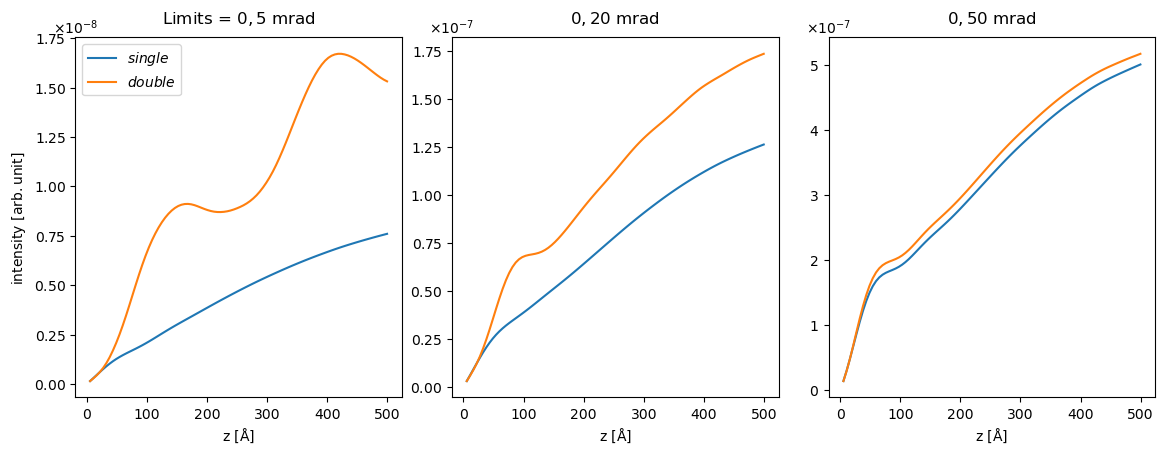

In [56]:
stacked = abtem.stack(
    [measurements_single[1:], measurements_double[1:]],
    axis_metadata=("single", "double"),
).integrate_radial(inner=0, outer=(5, 20, 50))

stacked.show(
    overlay=(1,), explode=(0,), figsize=(12, 4), common_scale=False, title=True
)

We see as expected that the single-channeling intensity is monotonically increasing function, in fact the intensity is just the cumulative sum of the result we calculated above
$$
I(z_{exit}) = \int_0^{z_{exit}} \frac{\mathrm{d}\sigma}{\mathrm{d}E}\left(z\right) \mathrm{d}z \quad .
$$



We see that the 

this is a good approximaxtion when the maximum collection angle is large, but may not be appropriate for smaller collection angles, as demonstrated below.

## 

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

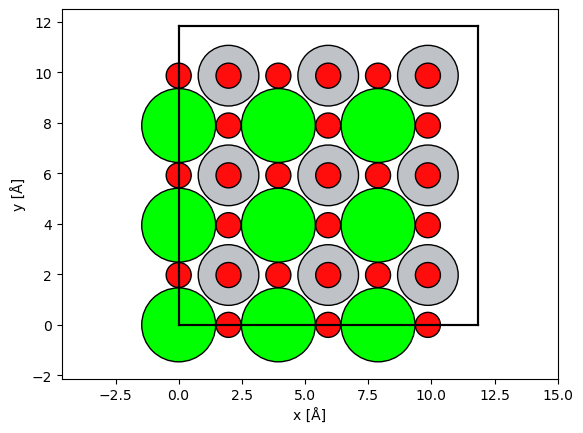

In [77]:
from ase.io import read

atoms = read("../walkthrough/data/srtio3_100.cif")

atoms *= (3,3,25)

O_transitions = SubshellTransitions(Z=Z, n=n, l=l, xc="PBE", order=1, epsilon=10)

abtem.show_atoms(atoms)

In [73]:
probe = abtem.Probe(
    semiangle_cutoff=25,
    energy=100e3,
    device="gpu",
)

probe.grid.match(potential)

potential = abtem.Potential(atoms, sampling=0.025, exit_planes=1)

transition_potentials_single = O_transitions.get_transition_potentials(double_channel=False)

position = (0, atoms.cell[0,0] / 6)

sites = atoms[np.linalg.norm(atoms.positions[:, :2]  - position, axis=1) < 0.1]

measurements_single = probe.build(position).transition_potential_multislice(
    potential=potential,
    detectors=detector,
    transition_potentials=transition_potentials_single,
    sites=sites,
)

measurements_single.compute()

tasks:   0%|          | 0/5 [00:00<?, ?it/s]

In [76]:
measurements_single.integrate_radial(inner=0, outer=60).array

array([9.9999988e-01, 0.0000000e+00, 1.7142813e-07, 1.7142813e-07,
       1.7142813e-07, 1.7142813e-07, 3.4342088e-07, 3.4342088e-07,
       3.4342088e-07, 3.4342088e-07, 5.1829136e-07, 5.1829136e-07,
       5.1829136e-07, 5.1829136e-07, 6.9701753e-07, 6.9701753e-07,
       6.9701753e-07, 6.9701753e-07, 8.7892136e-07, 8.7892136e-07,
       8.7892136e-07, 8.7892136e-07, 1.0623555e-06, 1.0623555e-06,
       1.0623555e-06, 1.0623555e-06, 1.2452556e-06, 1.2452556e-06,
       1.2452556e-06, 1.2452556e-06, 1.4255154e-06, 1.4255154e-06,
       1.4255154e-06, 1.4255154e-06, 1.6014556e-06, 1.6014556e-06,
       1.6014556e-06, 1.6014556e-06, 1.7716422e-06, 1.7716422e-06,
       1.7716422e-06, 1.7716422e-06, 1.9347362e-06, 1.9347362e-06,
       1.9347362e-06, 1.9347362e-06, 2.0896650e-06, 2.0896650e-06,
       2.0896650e-06, 2.0896650e-06, 2.2357585e-06, 2.2357585e-06,
       2.2357585e-06, 2.2357585e-06, 2.3727848e-06, 2.3727848e-06,
       2.3727848e-06, 2.3727848e-06, 2.5007921e-06, 2.5007921e

In [30]:
from ase.build import mx2

In [25]:
# Mo_transitions = SubshellTransitions(Z=42, n=n, l=l, xc="PBE", order=1, epsilon=10)

for bound_state, continuum_state in Mo_transitions.get_transition_quantum_numbers():
    print(f"(n, l, ml) -> (l', ml') = {bound_state} -> {continuum_state[1:]}")

NameError: name 'Mo_transitions' is not defined

In [ ]:
S_transitions.get_transition_potentials(double_channel=False).

In [31]:
S_transitions = SubshellTransitions(Z=16, n=1, l=0, xc="PBE", order=1, epsilon=10)

Mo_transitions = SubshellTransitions(
    Z=42, n=2, l=1, xc="PBE", order=1, epsilon=10, only_dipole=True
)

atoms = abtem.orthogonalize_cell(mx2("MoS2", vacuum=2)) * (3, 2, 1)

probe = abtem.Probe(
    semiangle_cutoff=30,
    energy=100e3,
    Cs=-0.053e-3 * 1e10,
    defocus=-90,
    C5=50e-3 * 1e10,
    device="gpu",
)

potential = abtem.Potential(atoms, sampling=0.05, exit_planes=1, slice_thickness=2)

probe.grid.match(potential)

scan = abtem.GridScan(
    start=(0, 0), end=(1 / 3, 1 / 2), fractional=True, potential=potential
)

transition_potentials = [
    Mo_transitions.get_transition_potentials(double_channel=False),
    S_transitions.get_transition_potentials(double_channel=False),
]
# waves = probe.multislice(potential, scan=scan, max_batch=20)
waves = probe.build(scan=scan, max_batch=40)

measurements = waves.transition_potential_multislice(
    potential=potential,
    detectors=detector,
    transition_potentials=transition_potentials,
)

measurements.compute(scheduler="single-threaded")

tasks:   0%|          | 0/44 [00:00<?, ?it/s]

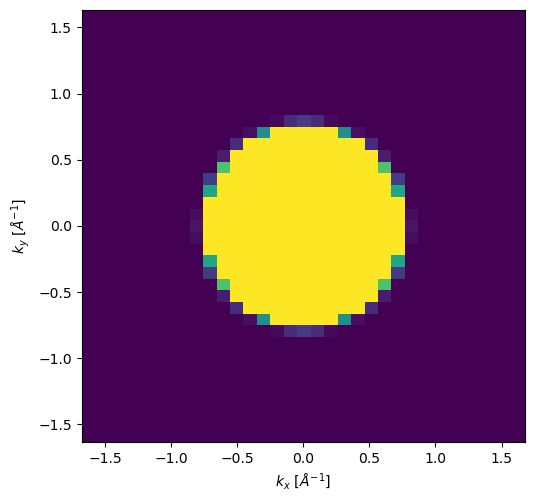

In [32]:
measurements.show()

In [ ]:
a = np.zeros((50, 50))
b = np.zeros((50, 50))
# a[...,0] = 1
# b[...,1] = 1

aa = np.random.rand(50, 50)
bb = np.random.rand(50, 50)

cmap = ListedColormap(["r"])

plt.imshow(a, alpha=aa, cmap=cmap)
plt.colorbar()

cmap = ListedColormap(["k", "b"])

#cmap(b)

#plt.imshow(b, alpha=bb, cmap=cmap)
#plt.colorbar()

In [ ]:
measurements.array.nbytes * 1e-9

In [ ]:
measurements.shape

In [52]:
integrated = (
    measurements[:, -1]
    .integrate_radial(0, 50)
    .tile((3, 2))
    .gaussian_filter(0.35)
    .interpolate(0.1)
) 

In [ ]:
alpha.min()

In [ ]:
integrated.array.shape

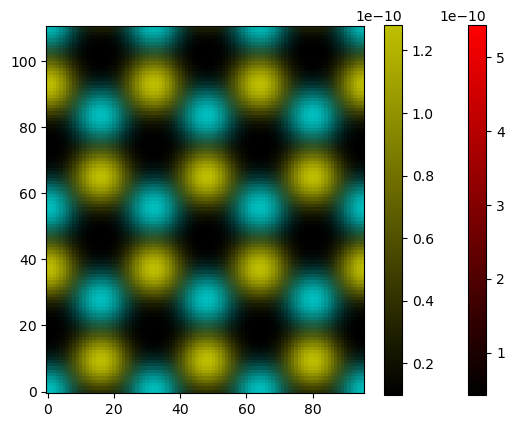

In [37]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
from matplotlib.cm import ScalarMappable


fig, ax = plt.subplots()
ax.set_facecolor("k")

cmap = ListedColormap(["c"])
norm = colors.Normalize()
norm.autoscale_None(integrated.array[0])
alpha = norm(integrated.array[0])

im = ax.imshow(np.ones_like(integrated.array[0]).T, alpha=alpha.T, cmap=cmap, origin="lower")

cmap = LinearSegmentedColormap.from_list("red", ["k", "r"])
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)

c = "y"
cmap = ListedColormap([c])
norm = colors.Normalize()
norm.autoscale_None(integrated.array[1])
alpha = norm(integrated.array[1])

im = ax.imshow(np.ones_like(integrated.array[1]).T, alpha=alpha.T, cmap=cmap, origin="lower")

cmap = LinearSegmentedColormap.from_list("c", ["k", c])
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)

In [ ]:
plt.imshow(alpha)
plt.colorbar()

In [ ]:
vis = (
    
    .show(explode=True, common_color_scale=False, cbar=True, vmin=0.) #, cmap=[["r"], ["g"]])
)  # "viridis")

vis.axes.set_sizes(padding=.1, cbar_spacing=.8)

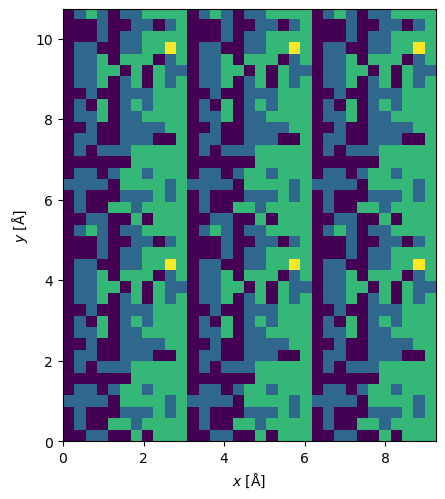

In [34]:
measurements.integrate_radial(inner=0, outer=50)[-1].tile((3, 2)).show()

In [ ]:
measurements.integrate_radial(inner=50, outer=150).interpolate(0.1).tile(
    (3, 2)
).gaussian_filter(0.35).show()

For a fast electron with an energy of 100 keV and a specified grid, we obtain the following transition potentials; the code will run an all-electron density function theory calculation using GPAW.

In [ ]:
atomic_transition_potentials.momentum_transfer

In [ ]:
atomic_transition_potentials = O_transitions.get_transition_potentials(
    extent=2, gpts=256, energy=100e3
)

In [ ]:
# atomic_transition_potentials.to_images()

In [ ]:
atomic_transition_potentials._energy_loss

In [ ]:
atomic_transition_potentials.to_images().show(
    explode=True, common_color_scale=True, cbar=True, figsize=(12, 6)
)

In [ ]:
atomic_transition_potentials.to_images().abs().array.sum(axis=(-2, -1))

In [ ]:
atomic_transition_potentials

Applying the selection rules

$$
 \Delta \ell = \pm 1
$$

we obtain the following dipole transitions.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for ax, atomic_transition_potential in zip(axes, atomic_transition_potentials):
    atomic_transition_potential.show(ax=ax, title=str(atomic_transition_potential))

We have created transition potentials for single atoms, now we need to put them together in a multislice simulation.

We import our `Atoms` as usual and make a 2$\times$2 supercell.

In [ ]:
atoms = read("data/srtio3_100.cif") * (2, 2, 1)
atoms.center(axis=2)

from abtem import show_atoms

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2))

show_atoms(atoms, ax=ax1, title="Beam view")
show_atoms(atoms, ax=ax2, plane="yz", title="Side view")
show_atoms(atoms[atoms.numbers == 8], ax=ax3, plane="xy", title="Beam view (Oxygen)");

Next, we create a `TransitionPotential`. The overlap integrals depend on the incoming energy, hence we have to provide the acceleration voltage. We also provide a sampling in order to show the potential below.

In [ ]:
transition_potential = TransitionPotential(
    O_transitions, atoms=atoms, sampling=0.05, energy=100e3, slice_thickness=2
)

We can show the projected intensity of the transition potential.

In [ ]:
transition_potential.show()

Finally, we can do a full "energy-filtered" STEM simulation targeting the oxygen *K* edge.

We create a scattering matrix `SMatrix` as usual (note: interpolation is not yet implemented!), and an `EELSDetector` (interpolation is implemented), as well as a standard electrotrostatic potential.

We also create a new `TransitionPotential`, which will automatically adopt the appropriate atoms and energy from the other simulation objects.

In [ ]:
S = SMatrix(energy=100e3, semiangle_cutoff=25)  # interpolation not implemented!


detector = EELSDetector(collection_angle=100, interpolation=4)


potential = Potential(
    atoms,
    sampling=0.05,
    slice_thickness=0.5,
    projection="infinite",
    parametrization="kirkland",
)


transition_potential = TransitionPotential(O_transitions)


scan = GridScan((0, 0), potential.extent, sampling=0.9 * S.ctf.nyquist_sampling)


measurement = S.coreloss_scan(scan, detector, potential, transition_potential)

We show the final (tiled, interpolated) energy-filtered image below.

In [ ]:
measurement.tile((2, 2)).interpolate(0.02).show(figsize=(6, 6));

We further target the *K*-edge of oxygen as above and the *L*$_{23}$-edge of titanium and strontium. We use the PBE functional to calculate the transitions.

In [ ]:
O_transitions = SubshellTransitions(Z=8, n=1, l=0, xc="PBE")
Ti_transitions = SubshellTransitions(Z=22, n=2, l=1, xc="PBE")
Sr_transitions = SubshellTransitions(Z=38, n=2, l=1, xc="PBE")

transitions = [O_transitions, Ti_transitions, Sr_transitions]

transition_potential = TransitionPotential(transitions)

In [ ]:
print("Oxygen:")
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f"(l, ml) = {bound_state} -> {continuum_state}")
print("Titanium:")
for bound_state, continuum_state in Ti_transitions.get_transition_quantum_numbers():
    print(f"(l, ml) = {bound_state} -> {continuum_state}")
print("Strontium:")
for bound_state, continuum_state in Sr_transitions.get_transition_quantum_numbers():
    print(f"(l, ml) = {bound_state} -> {continuum_state}")

In [ ]:
measurements = S.coreloss_scan(scan, detector, potential, transition_potential)

By abTEM convention, the first dimensions always represent the scan or navigation dimensions. Hence, in our case the third dimension represents the subshell of an electron (or, experimentally, a specific energy loss).

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2.7))

measurements[0].tile((2, 2)).interpolate(0.1).show(ax=ax1)
measurements[1].tile((2, 2)).interpolate(0.1).show(ax=ax2)
measurements[2].tile((2, 2)).interpolate(0.1).show(ax=ax3);

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

measurements[0].interpolate_line((0, 0), (0, potential.extent[1]), sampling=0.1).show(
    ax=ax1, label="O"
)
measurements[1].interpolate_line((0, 0), (0, potential.extent[1]), sampling=0.1).show(
    ax=ax1, label="Ti"
)
measurements[2].interpolate_line((0, 0), (0, potential.extent[1]), sampling=0.1).show(
    ax=ax1, label="Sr"
)
ax1.legend()

measurements[0].interpolate_line(
    (atoms[3].x, 0), (atoms[3].x, potential.extent[1]), sampling=0.1
).show(ax=ax2, label="O")
measurements[1].interpolate_line(
    (atoms[3].x, 0), (atoms[3].x, potential.extent[1]), sampling=0.1
).show(ax=ax2, label="Ti")
measurements[2].interpolate_line(
    (atoms[3].x, 0), (atoms[3].x, potential.extent[1]), sampling=0.1
).show(ax=ax2, label="Sr")
ax2.legend();